In [28]:
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as torch_function
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from glob import glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.utils import save_image, make_grid

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

In [3]:
print(get_device())

cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class DenoiseDataset(Dataset):
    def __init__(self, noisy_root, pure_root, transform=None):
        self.noisy_root = noisy_root
        self.pure_root = pure_root
        self.transform = transform

        self.samples = []
        self.classes = sorted(os.listdir(noisy_root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for cls in self.classes:
            noisy_class_dir = os.path.join(noisy_root, cls)
            pure_class_dir = os.path.join(pure_root, cls)
            files = os.listdir(noisy_class_dir)

            for fname in files:
                noisy_path = os.path.join(noisy_class_dir, fname)
                pure_path = os.path.join(pure_class_dir, fname)
                self.samples.append((noisy_path, pure_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        noisy_path, pure_path, label = self.samples[idx]

        noisy_img = Image.open(noisy_path).convert("RGB")
        pure_img = Image.open(pure_path).convert("RGB")

        if self.transform:
            noisy_img = self.transform(noisy_img)
            pure_img = self.transform(pure_img)

        return noisy_img, pure_img, label


train_dataset = DenoiseDataset(
    noisy_root="C:/Users/satyasrp/personal/projects/aiml/neural_networks/data/PlantVillage_Noisy_Dataset/PlantVillage/Noisy_Dataset/Train_Data",
    pure_root="C:/Users/satyasrp/personal/projects/aiml/neural_networks/data/PlantVillage_Noisy_Dataset/PlantVillage/Pure_Dataset/Train_Data",
    transform=transform
)

test_dataset = DenoiseDataset(
    noisy_root="C:/Users/satyasrp/personal/projects/aiml/neural_networks/data/PlantVillage_Noisy_Dataset/PlantVillage/Noisy_Dataset/Test_Data",
    pure_root="C:/Users/satyasrp/personal/projects/aiml/neural_networks/data/PlantVillage_Noisy_Dataset/PlantVillage/Pure_Dataset/Test_Data",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:

for noisy, pure, label in train_loader:
    print("Noisy Train:", noisy.shape, "Pure Train:", pure.shape, "Labels Train:", label.shape)
    break

for noisy, pure, label in test_loader:
    print("Noisy Test:", noisy.shape, "Pure Test:", pure.shape, "Labels Test:", label.shape)
    break

Noisy Train: torch.Size([16, 3, 128, 128]) Pure Train: torch.Size([16, 3, 128, 128]) Labels Train: torch.Size([16])
Noisy Test: torch.Size([16, 3, 128, 128]) Pure Test: torch.Size([16, 3, 128, 128]) Labels Test: torch.Size([16])


In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
    
        self.encoder_1 = nn.Linear(in_features=3*128*128, out_features=4096)
        self.encoder_2 = nn.Linear(in_features=4096, out_features=1024)

        self.decoder_1 = nn.Linear(in_features=1024, out_features=4096)
        self.decoder_2 = nn.Linear(in_features=4096, out_features=3*128*128)

    def forward(self, X):
        X = torch_function.relu(self.encoder_1(X))
        X = torch_function.relu(self.encoder_2(X))
        X = torch_function.relu(self.decoder_1(X))
        X = torch_function.sigmoid(self.decoder_2(X))

        return X
    
net = AutoEncoder()
print(net)

AutoEncoder(
  (encoder_1): Linear(in_features=49152, out_features=4096, bias=True)
  (encoder_2): Linear(in_features=4096, out_features=1024, bias=True)
  (decoder_1): Linear(in_features=1024, out_features=4096, bias=True)
  (decoder_2): Linear(in_features=4096, out_features=49152, bias=True)
)


In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)

In [14]:
def compute_test_loss(net, testloader, device, criterion):
    net.eval()
    total_loss = 0
    with torch.no_grad():
        for noisy_imgs, pure_imgs, _ in testloader:
            noisy_imgs, pure_imgs = noisy_imgs.to(device), pure_imgs.to(device)
            noisy_flat = noisy_imgs.view(noisy_imgs.size(0), 3*128*128)
            outputs = net(noisy_flat)
            outputs = outputs.view(-1, 3, 128, 128)
            loss = criterion(outputs, pure_imgs)
            total_loss += loss.item()
    return total_loss / len(testloader)

def train_autoencoder(net, trainloader, testloader, device, save_dir="reconstructed", NUM_EPOCHS=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-3)

    train_loss = []
    test_loss_list = []
    os.makedirs(save_dir, exist_ok=True)

    net.train()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0

        for noisy_imgs, pure_imgs, _ in trainloader:
            noisy_imgs, pure_imgs = noisy_imgs.to(device), pure_imgs.to(device)
            noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), 3*128*128)
            pure_imgs  = pure_imgs.view(pure_imgs.size(0), 3*128*128)
            optimizer.zero_grad()
            outputs = net(noisy_imgs)
            loss = criterion(outputs, pure_imgs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        train_loss.append(avg_loss)

        avg_test_loss = compute_test_loss(net, testloader, device, criterion)
        test_loss_list.append(avg_test_loss)
        
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        if (epoch+1) % 5 == 0:
            save_image(torch.cat([noisy_imgs[:8], pure_imgs[:8], outputs[:8]], dim=0).cpu(), f"{save_dir}/reconstructed_epoch{epoch+1}.png", nrow=8)

    return train_loss, test_loss_list


In [15]:
device = get_device()
print("This is my device -> ",device)
net.to(device)
train_loss, test_loss_list = train_autoencoder(net, train_loader, test_loader, device)


This is my device ->  cuda
Epoch [1/10], Train Loss: 0.0155, Test Loss: 0.0154
Epoch [2/10], Train Loss: 0.0149, Test Loss: 0.0152
Epoch [3/10], Train Loss: 0.0148, Test Loss: 0.0152
Epoch [4/10], Train Loss: 0.0146, Test Loss: 0.0154
Epoch [5/10], Train Loss: 0.0146, Test Loss: 0.0156
Epoch [6/10], Train Loss: 0.0144, Test Loss: 0.0153
Epoch [7/10], Train Loss: 0.0146, Test Loss: 0.0152
Epoch [8/10], Train Loss: 0.0144, Test Loss: 0.0153
Epoch [9/10], Train Loss: 0.0143, Test Loss: 0.0153
Epoch [10/10], Train Loss: 0.0141, Test Loss: 0.0154


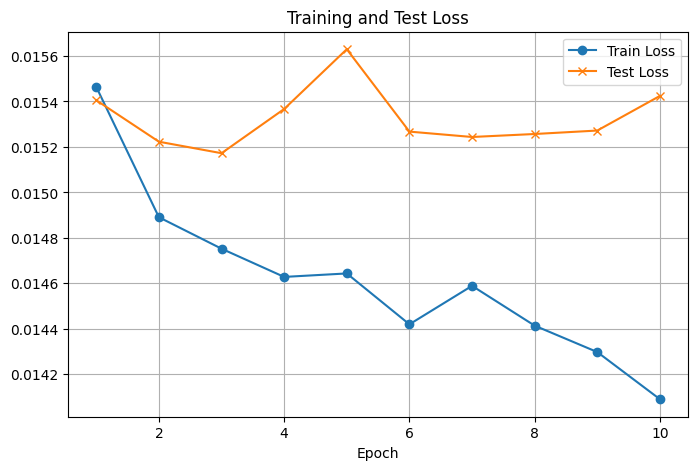

In [18]:
epochs = range(1, 10+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, test_loss_list, label='Test Loss', marker='x')
plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
def test_reconstruction(net, testloader, device):
    net.eval()
    with torch.no_grad():
        cnt= 0
        for noisy_imgs, pure_imgs, _ in testloader:
            noisy_imgs, pure_imgs = noisy_imgs.to(device), pure_imgs.to(device)

            # Flatten if using LinearAutoencoder
            noisy_flat = noisy_imgs.view(noisy_imgs.size(0), 3*128*128)
            outputs = net(noisy_flat)
            outputs = outputs.view(-1, 3, 128, 128)
            num=8
            noisy_imgs = noisy_imgs[:num].cpu()
            pure_imgs  = pure_imgs[:num].cpu()
            outputs    = outputs[:num].cpu()
            grid = torch.cat([noisy_imgs, pure_imgs, outputs], dim=0)
            grid_img = make_grid(grid, nrow=num)
            np_img = grid_img.permute(1, 2, 0).numpy()
            plt.figure(figsize=(num*2, 6))
            plt.imshow(np_img)
            plt.axis('off')
            plt.show()
            cnt+=1
            if cnt>5:
                break


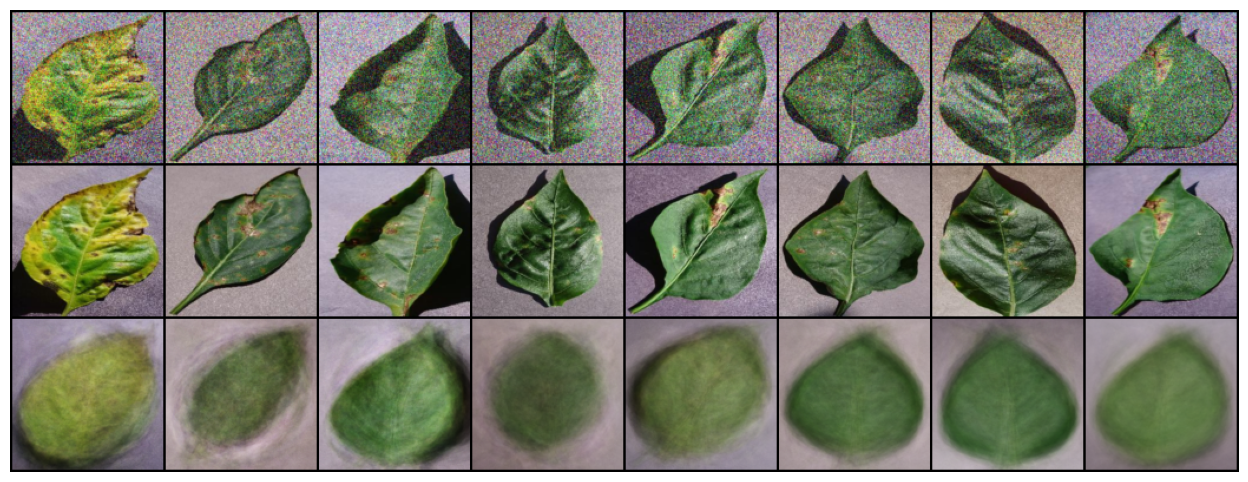

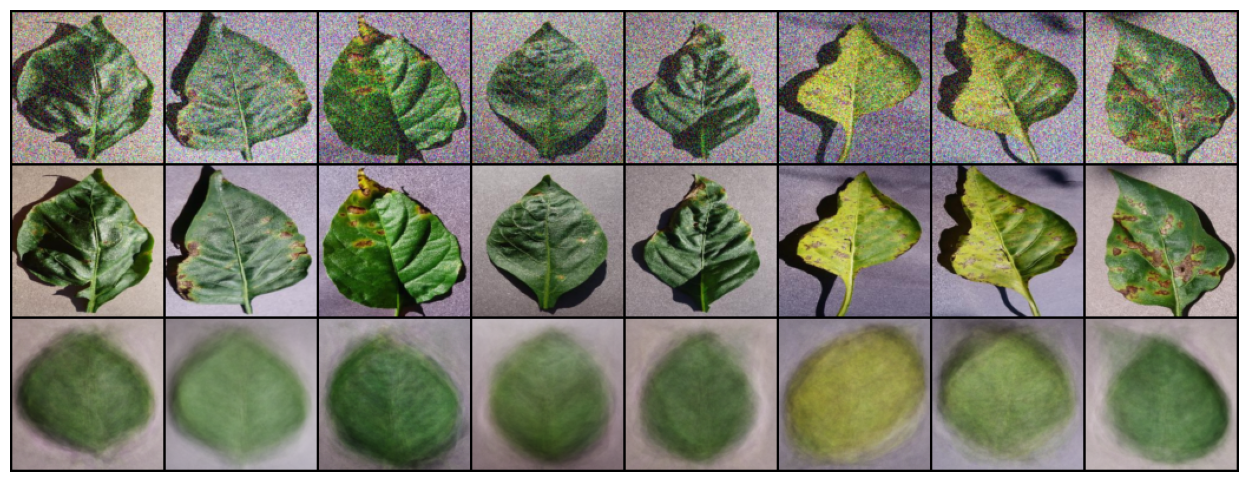

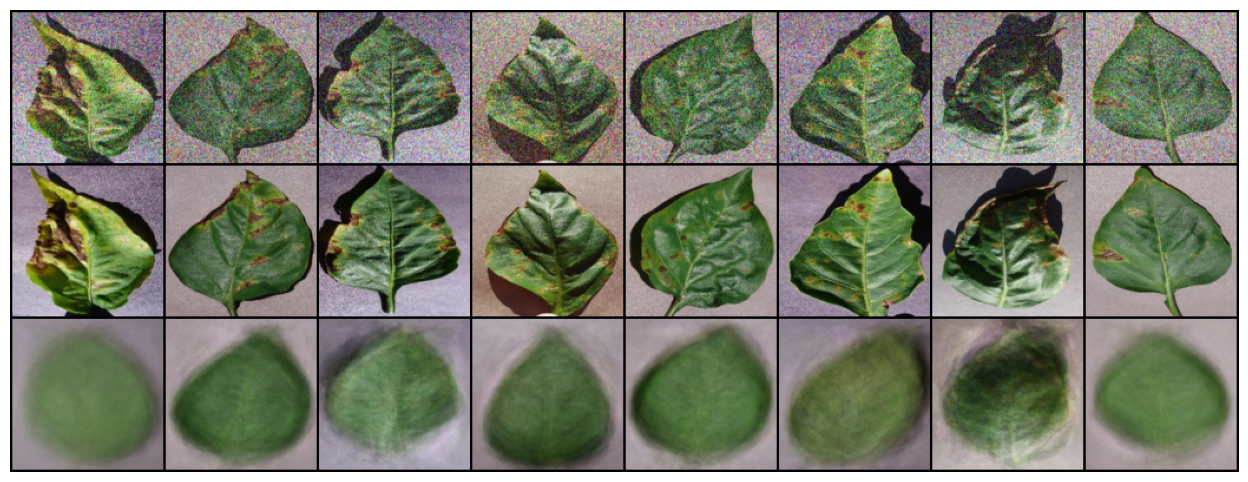

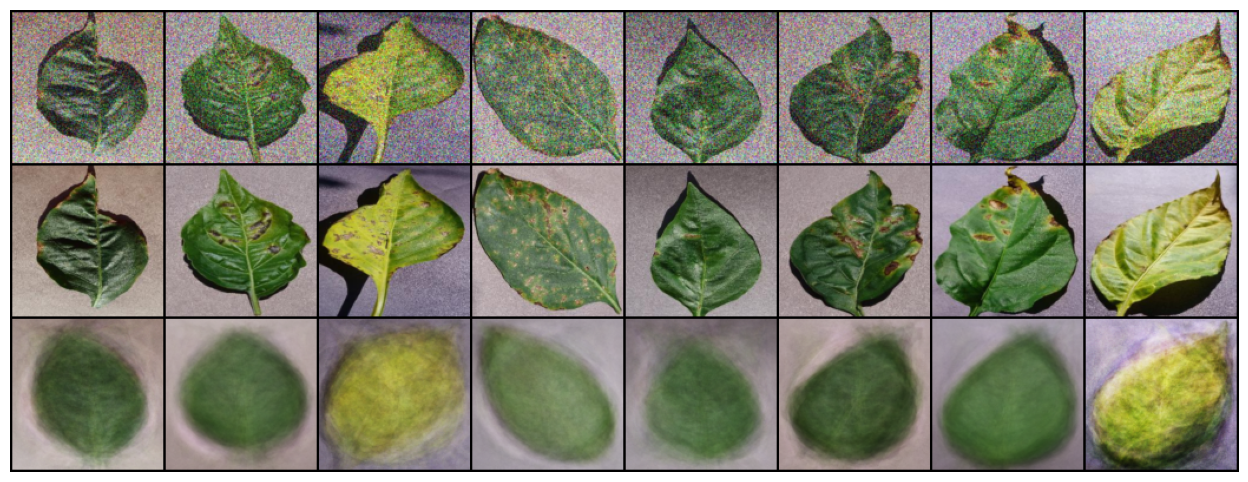

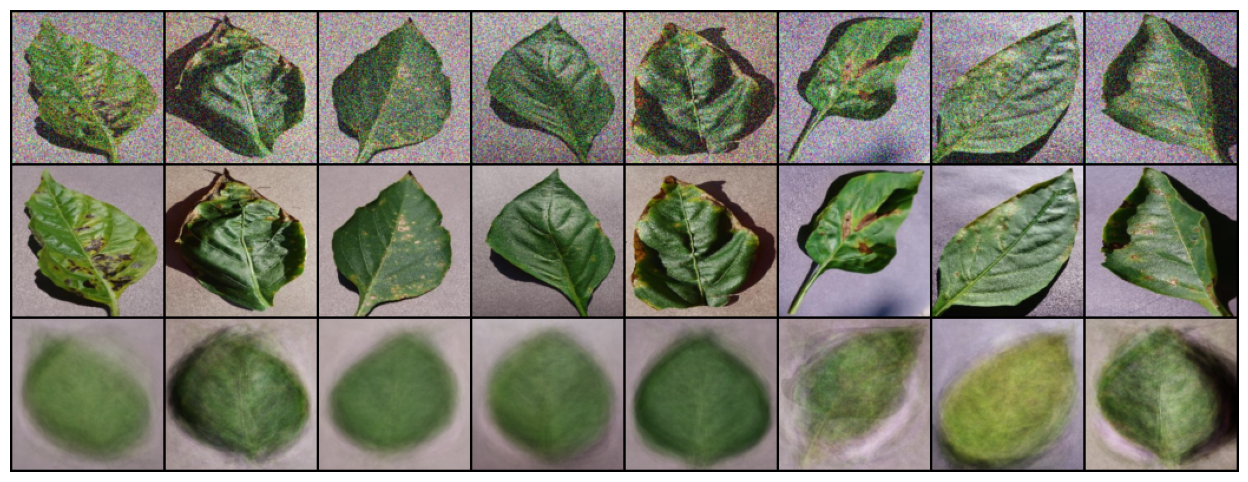

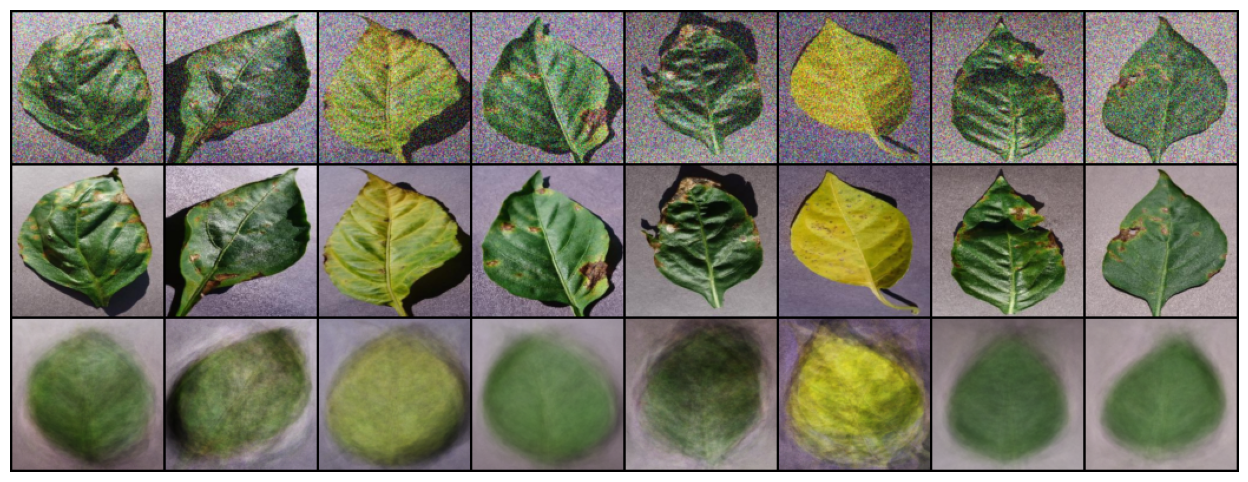

In [30]:
test_reconstruction(net, test_loader, device)